In [1]:
import os
import numpy as np

import darklim

from darklim.sensitivity._random_sampling import pdf_sampling

from scipy.special import factorial
import scipy.stats as stats

import matplotlib.pyplot as plt
if None != os.getenv('NERSC_HOST'):
    import matplotlib.font_manager as font_manager
    font_manager.fontManager.addfont('/global/cfs/cdirs/lz/physics/WS/SR1/msttcorefonts/Times_New_Roman.ttf')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'

from multihist import Hist1d

%matplotlib inline

In [2]:
E_LOW_GLOBAL_KEV = 1e-6
E_HIGH_GLOBAL_KEV = 100.
NPTS_GLOBAL = int(1e5)

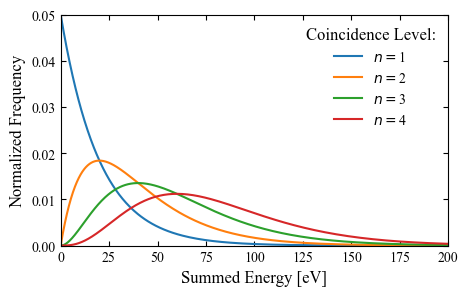

In [18]:
fig, ax = plt.subplots(1,figsize=(5,3))

lam = 1/20
ks = np.arange(1,5)
x = np.geomspace(1e-3,1e3,1000)

for k in ks:

    dist = stats.erlang.pdf(x,a=k,loc=0,scale=1/lam)
    dist2 = stats.expon.pdf(x,loc=0,scale=1/lam)

    plt.plot(x, dist,label=r'$n=$'+'{:d}'.format(k))
    
#plt.plot(x, dist2,'r--',label='Expo. Dist')
ax.set_xlim(0,200)
ax.set_ylim(0,0.05)
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.legend(loc='upper right',frameon=False,title='Coincidence Level:',title_fontsize=12)
ax.set_xlabel('Summed Energy [eV]',fontsize=12)
ax.set_ylabel('Normalized Frequency',fontsize=12)

plt.savefig('./pretty_plots/erlang.png',facecolor='white',bbox_inches='tight')

In [18]:
# generate ntoys
e_low = 1e-3
e_high = 10
npts = 1000

ntoys = 1000000

def power_bkgd(x,amplitude,abs_power):
    return amplitude * x**(-1*abs_power)
pdf = lambda x: power_bkgd(x,1.4e-8, 5.77)+power_bkgd(x,7.51e-11, 2.72)

#lam = 1/0.020
#pdf = lambda x: stats.expon.pdf(x,loc=0,scale=1/lam)


energy_res = 0.373e-3 # energy resolution in keV
#if var_threshold:
#    nsigma = stats.norm.isf(stats.norm.sf(5)**(1/coinc))
#else:
#    nsigma = 5
#per_device_threshold = nsigma * energy_res
#threshold = coinc*per_device_threshold
nsigma = 5
threshold = nsigma*energy_res

print('threshold = {:0.3e} keV'.format(threshold))
print('threshold = {:0.3e} eV'.format(threshold*1000))



threshold = 1.865e-03 keV
threshold = 1.865e+00 eV


In [21]:
# generate toys from m devices with n-fold coincidence

sum_all_energy = False

devices = np.array([1,2,3,4])

summed_energy = {}

for i,m in enumerate(devices): # loop over total number of devices
    
    # simulate events in all devices:
    evts = np.zeros((m,ntoys))
    for d in range(m):
        evts[d,:] = pdf_sampling( pdf, (e_low, e_high), npoints=npts, nsamples=ntoys )
    
    #print( evts[0,:10] )
    evts[np.where(evts<threshold)] = 0 # sets events below threshold to zero
    #print( evts[0,:10] )
    summed_energy[m] = np.sum(evts,axis=0) # sum energy accross devices
    
    #coinc = np.arange(2,m+1)
    #print('{} devices. coinc levels considered are '.format(m),coinc)
    
    #for j,n in enumerate(coinc):
    #    print('coinc level is ',n)
    #    
    #    # apply threshold to the first n channels
    #    for d in range(n):
    #        evts[d,:]
print('done.')

[0.00890226 0.00193366 0.01079027 0.00163338 0.00467823 0.00907259
 0.00135301 0.00893067 0.00977215 0.00495709]
[0.00890226 0.00193366 0.01079027 0.         0.00467823 0.00907259
 0.         0.00893067 0.00977215 0.00495709]
[0.0028602  0.00841154 0.00671738 0.00380692 0.00989576 0.00402931
 0.01010037 0.00149107 0.00516816 0.00806071]
[0.0028602  0.00841154 0.00671738 0.00380692 0.00989576 0.00402931
 0.01010037 0.         0.00516816 0.00806071]
[0.0034989  0.007528   0.00916924 0.00358474 0.00168518 0.00645742
 0.00662174 0.00107128 0.00932454 0.00543961]
[0.0034989  0.007528   0.00916924 0.00358474 0.         0.00645742
 0.00662174 0.         0.00932454 0.00543961]
[0.01026771 0.00553212 0.00389359 0.00553916 0.01084236 0.00924688
 0.00944472 0.00727594 0.00176651 0.00539641]
[0.01026771 0.00553212 0.00389359 0.00553916 0.01084236 0.00924688
 0.00944472 0.00727594 0.         0.00539641]
done.


Text(0.5, 0, 'Summed Energy [keV]')

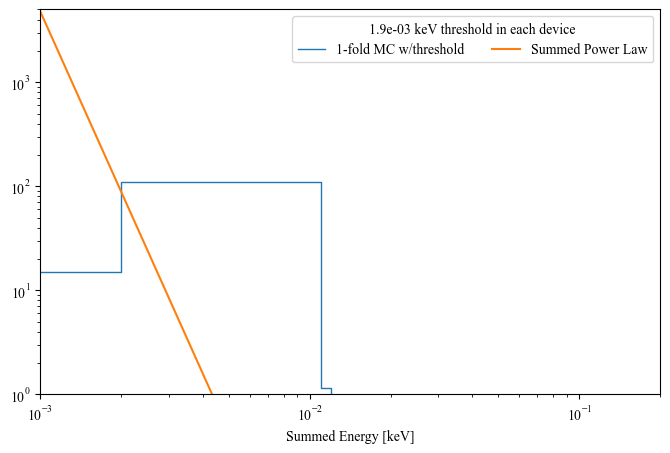

In [20]:
# histogram the simulated toys with PDF for single device
fig, ax = plt.subplots(1,figsize=(8,5))

m=1
h = Hist1d(summed_energy[m],bins=10000,range=(e_low,e_high))
bw = h.bin_centers[1]-h.bin_centers[0]
h.plot(scale_histogram_by=1/bw,lw=1,label='{}-fold MC w/threshold'.format(m),normed=True)

x = np.geomspace(e_low,e_high,10000)
#x = np.linspace(e_low,e_high,10000)

dist = pdf(x)
plt.plot(x, dist/np.trapz(dist, x=x),label='Summed Power Law')
        

ax.set_xlim(e_low,0.2)
ax.set_xscale('log')
ax.set_ylim(1,None)
ax.set_yscale('log')
ax.legend(loc='upper right', title='{:0.1e} keV threshold in each device'.format(threshold),ncol=2)
ax.set_xlabel('Summed Energy [keV]')

1
2
3
4


Text(0.5, 0, 'Summed Energy [keV]')

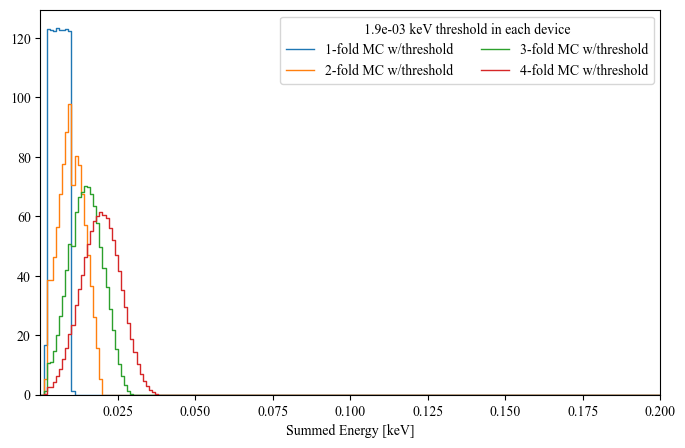

In [13]:
# histogram the simulated toys
fig, ax = plt.subplots(1,figsize=(8,5))

for i,m in enumerate(devices):
    h = Hist1d(summed_energy[m],bins=10000,range=(e_low,e_high))
    bw = h.bin_centers[1]-h.bin_centers[0]
    h.plot(scale_histogram_by=1/bw,lw=1,label='{}-fold MC w/threshold'.format(m),normed=True)

#x = np.geomspace(e_low,e_high,10000)
#x = np.linspace(e_low,e_high,10000)
#for k in devices:
#    dist = stats.erlang.pdf(x,a=k,loc=0,scale=1/lam)
#    plt.plot(x, dist/np.trapz(dist, x=x),label='Erlang, k={:d}'.format(k))
        

ax.set_xlim(e_low,0.2)
#ax.set_xscale('log')
ax.set_ylim(0,None)
ax.legend(loc='upper right', title='{:0.1e} keV threshold in each device'.format(threshold),ncol=2)
ax.set_xlabel('Summed Energy [keV]')

In [25]:
test = pdf_sampling( pdf, (e_low, e_high), npoints=npts, nsamples=ntoys )
print(test)
test[np.where(test<0.02)] = 0
print(test)

[0.01814909 0.08861029 0.02425482 ... 0.00364906 0.00120441 0.01921873]
[0.         0.08861029 0.02425482 ... 0.         0.         0.        ]


In [24]:
test

array([0.06928629, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

10000


Text(0.5, 0, 'Summed Energy [keV]')

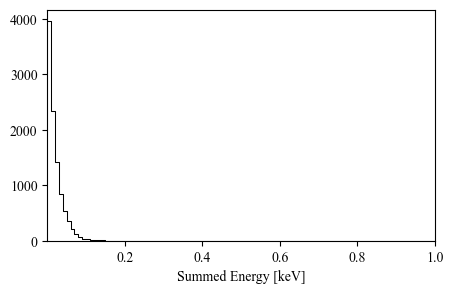

In [6]:
# histogram the simulated toys
fig, ax = plt.subplots(1,figsize=(5,3))

h = Hist1d(evts_sim,bins=npts,range=(e_low,e_high))
h.plot(color='black',lw=0.75)

print(h.n)

ax.set_xlim(e_low,1)
#ax.set_xscale('log')
ax.set_ylim(0,None)
#ax.legend(loc='upper right')
ax.set_xlabel('Summed Energy [keV]')

In [4]:
# Detector info setup

#n_devices = 4
#coinc = 2
#window = 100e-6 # s

mass_det = 0.00115 # mass in kg
time_elapsed = 1000 # days
efficiency = 1.0

tm = 'He' # target name

energy_res = 0.373e-3 # energy resolution in keV
#threshold = coinc*5*energy_res

print('detector mass is {} kg = {} g'.format(mass_det,mass_det*1000))
print('run time is {} days'.format(time_elapsed))
print('exposure is {} kg-days'.format(mass_det*time_elapsed))
#print('threshold = {:0.3f} eV'.format(threshold*1000))
#print('assuming {:d}-fold coincidence amongst {:d} devices in a {:0.1f} microsecond window'.format(coinc,n_devices,window/1e-6))

detector mass is 0.00115 kg = 1.15 g
run time is 1000 days
exposure is 1.15 kg-days


In [ ]:
SE = darklim.sensitivity.SensEst(mass_det, time_elapsed, eff=efficiency, tm=tm)

SE.reset_sim()
#SE.add_flat_bkgd(1) # flat background of 1 DRU
#SE.add_nfold_lee_bkgd(m=4,n=2,w=window)
SE.add_nfold_lee_bkgd(m=n_devices,n=coinc,w=window)

In [ ]:
# p-values to demonstrate the sf and isf functions:
p_sig = np.zeros(6) # p values
sigma = np.zeros(6) # sigmas
for sig in range(1,6):
    p_sig[sig-1] = stats.norm.sf(sig)
    sigma[sig-1] = stats.norm.isf(p_sig[sig-1])
    print('p-value for {:d} sigma is {:0.5e}'.format(sig,p_sig[sig-1]))
    print(' ->check that sigma is {:0.2f}\n'.format(sigma[sig-1]))